In [42]:
import numpy as np
import matplotlib.pyplot as plt
from kitti_foundation import Kitti, Kitti_util
import cv2
import math
from math import cos, sin, radians, pi
from src import settings as st
import seaborn as sns
%matplotlib inline

In [79]:
settings = st.Settings()
data_path = './dataset/2011_09_30/'
velo_path = data_path + '/sequences/velodyne'
fr = 402

(370, 1226, 3)


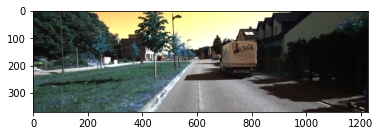

In [80]:
image_path = data_path + '/color/image_02'

# print frame 89 camera image
camera = Kitti(frame=fr,camera_path=image_path)
image = camera.camera_file

plt.imshow(image)
print(image.shape)

In [81]:
def print_projection_cv2(points, color, image):
    """ project converted velodyne points into camera image """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    for i in range(points.shape[1]):
        cv2.circle(hsv_image, (np.int32(points[0][i]),np.int32(points[1][i])),2, (int(color[i]),255,255),-1)

    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

def print_projection_plt(points, color, image):
    """ project converted velodyne points into camera image """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    for i in range(points.shape[1]):
        cv2.circle(hsv_image, (np.int32(points[0][i]),np.int32(points[1][i])),2, (int(color[i]),255,255),-1)

    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)

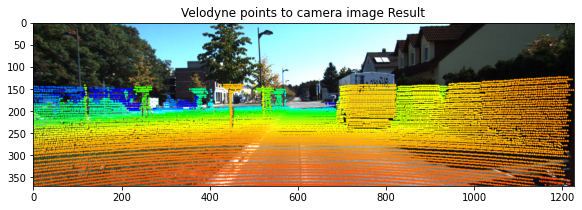

In [82]:
""" save one frame about projecting velodyne points into camera image """
v_fov, h_fov = (-24.9, 20.0), (-90, 90)

v2c_filepath = data_path + '/calibration/calib_velo_to_cam.txt'
c2c_filepath = data_path + '/calibration/calib_cam_to_cam.txt'

res = Kitti_util(frame=fr, camera_path=image_path, velo_path=velo_path, \
                v2c_path=v2c_filepath, c2c_path=c2c_filepath)

img, pnt, c_  = res.velo_projection_frame(v_fov=v_fov, h_fov=h_fov)

result = print_projection_plt(pnt, c_, img)

# display result image
plt.subplots(1,1, figsize = (13,3) )
plt.title("Velodyne points to camera image Result")
plt.imshow(result)

In [133]:
# res = Kitti_util(frame=fr, velo_path=velo_path)
# x_range, y_range, z_range, scale = (-20, 20), (-20, 20), (-2, 1), 10
x_range, y_range, z_range, scale = (-20, 40), (-12, 12), (-2, 1), 10
pnt_velo, c = res.velo_points(x_range=x_range, y_range=y_range, z_range=z_range)
# img, pnt_velo, c_  = res.velo_2_cam_projection_frame(v_fov=v_fov, h_fov=h_fov)
grid = np.zeros([settings.grid_size_x, settings.grid_size_y])
grid_avg = np.zeros([settings.grid_size_x, settings.grid_size_y])
print(grid.shape)
print(pnt_velo.shape)
pnt_velo

(300, 120)
(4, 97199)


array([[21.68700027, 21.66699982, 14.5369997 , ...,  3.74099994,
         3.74600005,  3.76699996],
       [ 2.56100011,  2.62800002,  2.05699992, ..., -1.41499996,
        -1.403     , -1.398     ],
       [ 0.94800001,  0.94700003,  0.70599997, ..., -1.74899995,
        -1.74899995, -1.75800002],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ]])

In [134]:
idx_quantizized = np.floor([pnt_velo[0,:]/settings.cell_size_x, pnt_velo[1,:]/settings.cell_size_y])
idx_quantizized_trans = [idx_quantizized[0,:] - settings.grid_xb/settings.cell_size_x,
                         idx_quantizized[1,:] - settings.grid_yr/settings.cell_size_y]
print(idx_quantizized.shape)
for i in range(idx_quantizized.shape[0]):
    print(idx_quantizized[i][:])
    print(idx_quantizized_trans[i][:])

(2, 97199)
[108. 108.  72. ...  18.  18.  18.]
[208. 208. 172. ... 118. 118. 118.]
[12. 13. 10. ... -8. -8. -7.]
[72. 73. 70. ... 52. 52. 53.]


In [135]:
cell_points = []
for i in range(settings.grid_size_x):
    for j in range(settings.grid_size_y):
#         print(i,j)
        idx = (idx_quantizized_trans[:][0] == i) & (idx_quantizized_trans[:][1] == j) 
#         print(len(idx))
        if np.sum(idx) != 0.:
#             id_cp = settings.grid_size_x*i + j  
#             print(id_cp)
            cell_points = np.asarray(pnt_velo[2,idx])
#             print(cell_points)
            grid[-i,-j] = np.max(cell_points)
            grid_avg[-i,-j] = np.mean(cell_points)

<AxesSubplot:>

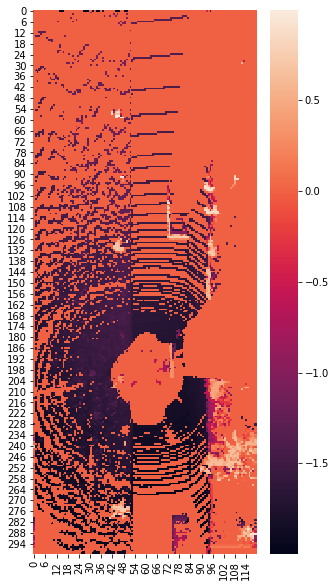

In [136]:
sns.color_palette("flare", as_cmap=True)
fig, ax = plt.subplots(1,1,figsize= (5,10))
sns.heatmap(ax=ax, data=grid)

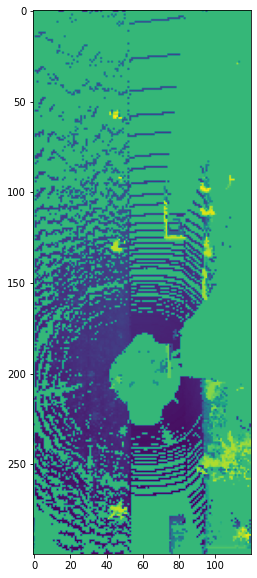

In [137]:
plt.subplots(1,1, figsize = (10,10))
plt.imshow(grid)